In [1]:
from mpc import *
from sympy import *
from IPython.display import display, Markdown, Latex

### Model linearization
Linearisation of the system around an operating condition.

In [2]:
k_m0_L = 3.20e-2  
k_m0_T = 1.19e-1  
k_m_L = 8.30
k_m_T = 2.06
k_p_L = 9.726e-1  
k_p_T = 9.726e-1  
g_m_L = 1.386e-1
g_m_T = 1.386e-1
g_p_L = 1.65e-2
g_p_T = 1.65e-2
theta_LacI = 31.94
theta_TetR = 30.00
theta_IPTG = 9.06e-2
theta_aTc = 11.65
eta_LacI = 2.00
eta_TetR = 2.00
eta_IPTG = 2.00
eta_aTc = 2.00

x1 = Symbol('x1')
x2 = Symbol('x2')
x3 = Symbol('x3')
x4 = Symbol('x4')
v1 = Symbol('v1')
v2 = Symbol('v2')

dx1 = k_m0_L + k_m_L*(1 / (1 + ((x4/theta_TetR) * (1 / (1 + (v1/theta_aTc)**eta_aTc)))**eta_TetR)) - g_m_L * x1
dx2 = k_m0_T + k_m_T*(1 / (1 + ((x3/theta_LacI) * (1 / (1 + (v2/theta_IPTG)**eta_IPTG)))**eta_LacI)) - g_m_T * x2
dx3 = k_p_L * x1 - g_p_L * x3
dx4 =  k_p_T * x2 - g_p_T * x4

In [3]:
A = [
        [dx1.diff(x1), dx1.diff(x2), dx1.diff(x3), dx1.diff(x4)],
        [dx2.diff(x1), dx2.diff(x2), dx2.diff(x3), dx2.diff(x4)],
        [dx3.diff(x1), dx3.diff(x2), dx3.diff(x3), dx3.diff(x4)],
        [dx4.diff(x1), dx4.diff(x2), dx4.diff(x3), dx4.diff(x4)]
    ]

B = [
        [dx1.diff(v1), dx1.diff(v2)],
        [dx2.diff(v1), dx2.diff(v2)],
        [dx3.diff(v1), dx3.diff(v2)],
        [dx4.diff(v1), dx4.diff(v2)]
    ]

C = [
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ]

D = [
        [0, 0],
        [0, 0]
    ]

In [4]:
point = 650

with open('./data/deterministic/results0.json') as f:
    data = json.load(f)
    aTc = data['inputs']['aTc'][point]
    iptg = data['inputs']['IPTG'][point]
    mRNA_LacI = data['states']['mRNA_LacI'][point]
    mRNA_TetR = data['states']['mRNA_TetR'][point]
    LacI = data['states']['LacI'][point]
    TetR = data['states']['TetR'][point]

In [5]:
equilibria = np.array([mRNA_LacI, mRNA_TetR, LacI, TetR, aTc, iptg])

In [6]:
f = lambdify([(x1, x2, x3, x4, v1, v2)], A)
A = np.array(f(equilibria))

f = lambdify([(x1, x2, x3, x4, v1, v2)], B)
B = np.array(f(equilibria))

### Simulation parameters
Defines the total simulation time and sampling time.

In [7]:
# Total simulation time: 24h (1440m)
total_time = 1440  

# Sampling time: 1m
t_step = 5

# Number of control step: total_time/t_step = 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# Initial conditions
x_0 = np.array([30, 50, 400, 125])

# References
LacI_ref = 750
TetR_ref = 300


### Control loop

It defines the parameters of the controller, instantiates the object of the model class to be controlled and the object of the controller class and starts the control loop.

In [8]:
setup_mpc = {
    'n_robust': 1,
    'n_horizon': 7,
    't_step': t_step,
    'store_full_solution': False,
}

toggle = ToggleSwitchLinearModel(False, LacI_ref, TetR_ref, t_step, total_time, avg_period, A, B)
mpc_controller = ControllerMPC(toggle, t_step, setup_mpc, False)
mpc_controller.control_loop(x_0, steps, 'linear', 1)

### Performance metrics and results plot
It calculates ISE and ITAE values and plots closed-loop simulations.

#### Performance metrics


<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | 0.12     |
| ITAE       | 3.19e+03    |


#### Results plot

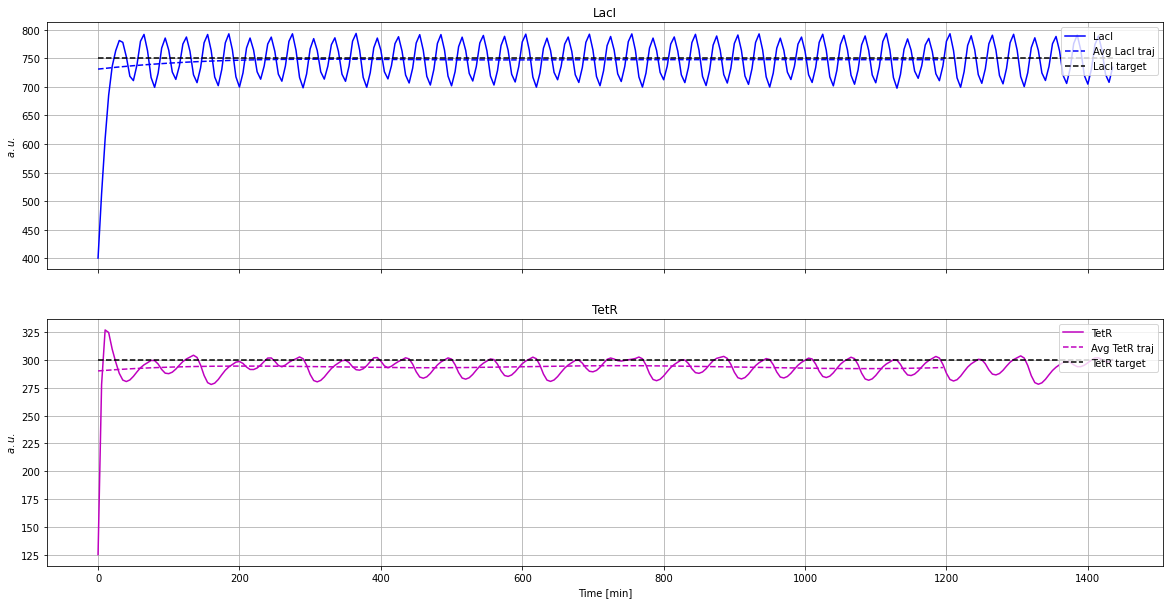

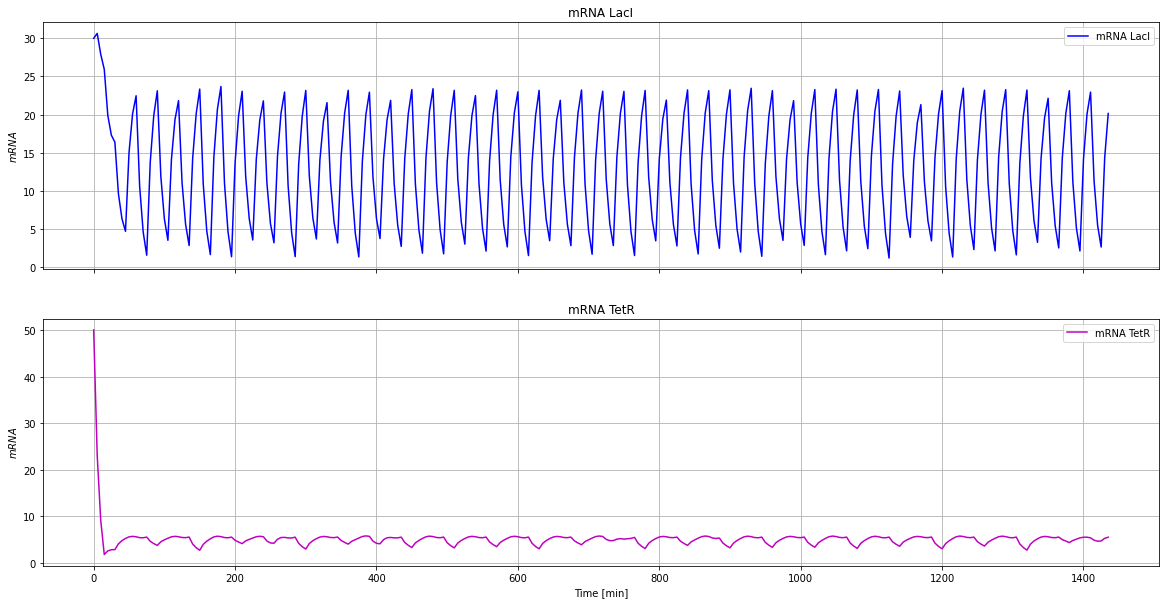

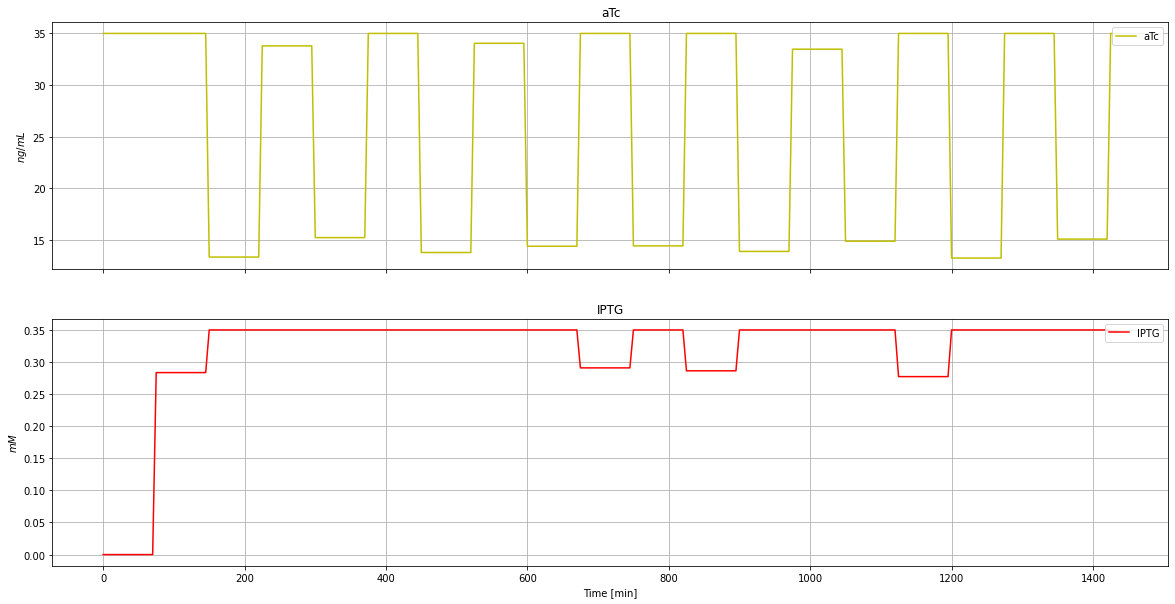

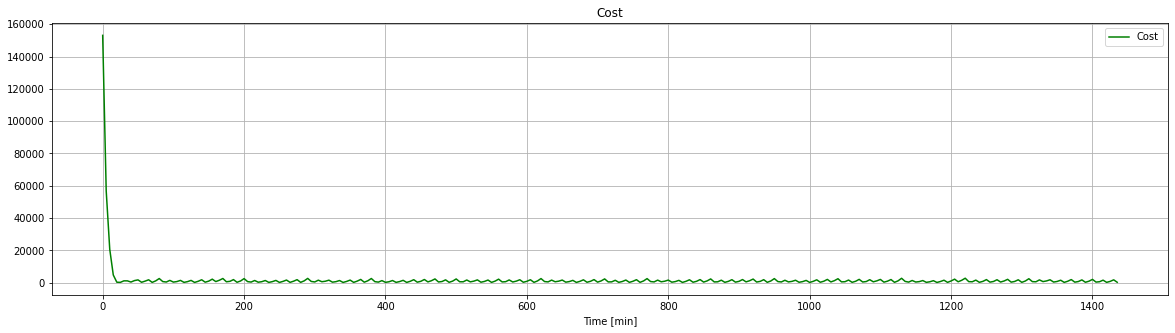

In [9]:
display(Markdown('#### Performance metrics'))
metrics = """
<center>

| **Metric** | **Value** |
|------------|-----------|
| ISE        | {ISE}     |
| ITAE       | {ITAE}    |
""".format(ISE = "{:.2f}".format(toggle.trajectories['ISE']), ITAE = format(toggle.trajectories['ITAE'], '.2e'))

display(Markdown(metrics))

display(Markdown('#### Results plot'))
figures, lines = toggle.plot_results()

### Plots animation
It animates closed-loop simulations and exports them in mp4 format.

In [10]:
toggle.animate_results('linear', 'proteins', toggle.update_protein, figures[0], (toggle.trajectories, lines[0:6], np.arange(0, total_time - ((total_time-1) % avg_period) - 1, t_step)), steps)
toggle.animate_results('linear', 'mRNAs', toggle.update_mRNA, figures[1], (toggle.trajectories, lines[6:8]), steps)
toggle.animate_results('linear', 'external_inducers', toggle.update_external_inducers, figures[2], (toggle.trajectories, lines[8:10]), steps)
toggle.animate_results('linear', 'cost', toggle.update_cost, figures[3], (toggle.trajectories, lines[10:11]), steps)